In [39]:
import scipy.signal as sp
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import math
from matplotlib.widgets import Slider, Button

In [188]:
def generate_stimuli(pos = [0, 0], size=20):
    if type(pos) == list:
        pos = np.asarray(pos).reshape(1, len(pos))
        
    stims = np.zeros([size, size, pos.shape[0]])
    
    for i in range(pos.shape[0]):
        center = pos[i]
        x = round(pos[i, 0]) + int(size/2)
        y = round(pos[i, 1]) + int(size/2)
        
        stims[y, x, i] = 1
    
    return np.squeeze(stims), pos


def generate_prf(center = [0, 0], size=20, sd=10):
    x = np.arange(-int(size/2), int(size/2), 1, float)
    y = x[:,np.newaxis]
    
    prf =  np.exp(- ((x-center[0])**2 + (y-center[1])**2) / (2*sd**2))
    
    return prf


def generate_voxels(deg_radius=20, n_eccentricities=10, prf_slope=0.2, prf_intercept = 0.6):
    # v1, v2 slope = 0.2
    # v3 = 0.25
    # hV4 = 0.5
    pos = np.linspace(0, deg_radius, n_eccentricities)
    xs = np.concatenate([-pos[:0:-1], pos])
    ys = xs[:, np.newaxis][::-1]

    voxels = []

    for x in xs.flatten():
        for y in ys.flatten():
            ecc = np.linalg.norm(np.array([x, y]))
            prf_size = ecc * prf_slope + prf_intercept

            voxels.append([x, y, ecc, prf_size])

    voxels = np.asarray(voxels)
    
    return voxels


def generate_isostim(eccentricity, n_pos, size):
    xstart = np.arange(0, 2*np.pi, 2*np.pi / n_pos)
    xstop = xstart + 2*np.pi / n_pos
    x = np.random.uniform(xstart, xstop)
    
    positions = eccentricity * np.array([np.sin(x), np.cos(x)]).T 
    
    stims, pos = generate_stimuli(positions, size = size)
    
    return stims, positions, x


def gen_pRFresponses(near_ecc, target_ecc, stims, prf_maps, voxels, positions):
    # near_ecc = 2
    # stim = stims[:, :, slice]
    # angle_s = angles[slice]
    # pos = positions[slice]
    # angle = np.arctan2(pos[1], pos[0])
    # coords = np.where(stim == 1)
    # threshold = 0.01
    target_idxs = np.where((voxels[:, 2] <= target_ecc + near_ecc) & (voxels[:, 2] >= target_ecc - near_ecc))
    target_voxels = voxels[target_idxs]
    target_prf_maps = prf_maps[:, :, target_idxs].squeeze()
    prf_responses = np.zeros([len(target_voxels), 6, stims.shape[-1]])     
    
    for s in range(stims.shape[-1]):
        stim = stims[:, :, s]
        prf_resps = []
        pos = positions[s]
        angle = np.arctan2(pos[1], pos[0])
        
        for i, v in enumerate(target_voxels):
            x, y, ecc, prf_size = v
            prf = target_prf_maps[:, :, i]
            prf_resp = stim.flatten() @ prf.flatten()
            vox_deg_in_rads = np.arctan2(y, x)

            vox_diff = angle - vox_deg_in_rads
            prf_resps.append([x, y, ecc, vox_deg_in_rads, vox_diff, prf_resp])

        prf_responses[:, :, s] = np.asarray(prf_resps)
    
    return prf_responses


def gen_LTMstims(stims, size, sd = 4.5):
    filt = generate_prf(size = size*2, sd = sd)
    ltm_stims = np.zeros([size, size, stims.shape[-1]])
    
    for s in range(stims.shape[-1]):
        stim = stims[:, :, s]
        stim_conv = sp.convolve2d(stim, filt, mode = 'same')
        #edge = int(stim_conv.shape[0]/2 - stim.shape[0]/2)

        #stim_conv = stim_conv[edge+1:-edge, edge+1:-edge]
        stim_conv /= stim_conv.sum()
        ltm_stims[:, :, s] = stim_conv
    
    ltm_stims = np.asarray(ltm_stims)
    
    return ltm_stims
        

(0.0, 1.0)

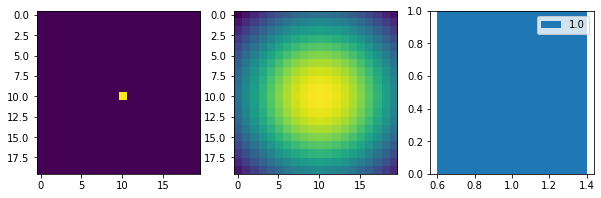

In [189]:
stim, pos = generate_stimuli()
prf = generate_prf() 
prf_resp = stim.flatten() @ prf.flatten()

fig, axs = plt.subplots(1, 3)
fig.set_size_inches(10, 3)

axs[0].imshow(stim[:,:])

axs[1].imshow(prf)
axs[2].bar(1, prf_resp)
axs[2].legend([prf_resp])
axs[2].set_ylim([0, 1])

In [190]:
target_ecc, near_ecc = 7, 2
target_idxs = np.where((voxels[:, 2] <= target_ecc + near_ecc) & (voxels[:, 2] >= target_ecc - near_ecc))
print(target_idxs)
prf_maps[:, :, target_idxs].squeeze().shape

(array([2721, 2722, 2723, ..., 7077, 7078, 7079]),)


(50, 50, 1052)

In [191]:
ltm_stims.shape

(50, 50, 16)

In [213]:
size = 40
n_pos = 16
target_ecc = 7
near_ecc = 1.5
n_ecc = 50

print("Generating voxels...")
voxels = generate_voxels(n_eccentricities = n_ecc)
prf_maps = np.zeros([size, size, voxels.shape[0]])
print("Generating Stimuli...")
stims, positions, angles = generate_isostim(target_ecc, n_pos, size = size)
print("Generating LTM simulated sources...")
ltm_stims = gen_LTMstims(stims, size, sd = 4)

print("Generating pRF maps...")
for i, v in enumerate(voxels):
    x, y, ecc, prf_size = v
    prf_maps[:, :, i] = generate_prf(center = [x, y], size = size, sd = prf_size)

print("Generating pRF responses...")
parf_perception = gen_pRFresponses(near_ecc, target_ecc, stims, prf_maps, voxels, positions)
parf_ltm = gen_pRFresponses(near_ecc, target_ecc, ltm_stims, prf_maps, voxels, positions) 


Generating voxels...
Generating Stimuli...
Generating LTM simulated sources...
Generating pRF maps...
Generating pRF responses...


In [214]:
# TODO: Generate prfresponses for each stimuli before initializing widget - for faster visualization
@widgets.interact(slice=widgets.IntSlider(min=0, max=stims.shape[-1] - 1, step=1, value=0))
def plot_prfs(slice):
    ''' ----- Perception ----- '''
    stim = stims[:, :, slice]
    angle_s = angles[slice]
    pos = positions[slice]
    #angle = np.arctan2(pos[1], pos[0])
    coords = np.where(stim == 1)
    threshold = 0.01

    fig, axs = plt.subplots(2, 3)
    fig.set_size_inches(15, 8)


    axs[0, 1].scatter(parf_perception[:, 0, slice], parf_perception[:, 1, slice], s = 5, c = parf_perception[:, -1, slice])
    axs[0, 1].scatter(positions[slice, 0], positions[slice, 1], color = 'orange')

    zero_idxs = np.where(parf_perception[:, 5, slice] <= threshold)

    axs[0, 1].scatter(parf_perception[zero_idxs, 0, slice], parf_perception[zero_idxs, 1, slice], color = 'red', s=3)

    xmax = parf_perception[np.where(parf_perception[:, -1, slice] == parf_perception[:, -1, slice].max()), 0]
    ymax = parf_perception[np.where(parf_perception[:, -1, slice] == parf_perception[:, -1, slice].max()), 1]

    axs[0, 1].set_xlim([-20, 20])
    axs[0, 1].set_ylim([-20, 20])
    axs[0, 1].axis('equal')
    axs[0, 2].scatter(parf_perception[:, 4, slice], parf_perception[:, 5, slice])
    axs[0, 2].set_ylim([0, 1])
    axs[0, 2].set_xlim([-np.pi, np.pi])

    axs[0, 0].imshow(stim, origin = 'lower', vmax = 1)
    
    axs[0, 0].set_title('Source Input (Stimulus)')
    axs[0, 1].set_title('Voxel-wise map of Spatial Stimuli')
    axs[0, 1].scatter(0, 0, marker = "+")
    axs[0, 1].legend(['Voxels', 'Stimulus', 'Sub-threshold voxels'], loc = 'lower left',
                 fontsize = 8)
    ''' ----- LTM -----'''
    near_ecc = 2
    ltm_stim = ltm_stims[:, :, slice]
    angle_s = angles[slice]
    pos = positions[slice]
    #angle = np.arctan2(pos[1], pos[0])
    coords = np.where(stim == 1)
    
    print("\tRed Vox Threshold:", threshold)


    axs[1, 1].scatter(parf_ltm[:, 0, slice], parf_ltm[:, 1, slice], s = 5, c = parf_ltm[:, -1, slice])
    axs[1, 1].scatter(positions[slice, 0], positions[slice, 1], color = 'orange')
    axs[1, 1].scatter(0, 0, marker = "+")

    zero_idxs = np.where(parf_ltm[:, 5, slice] <= threshold)

    axs[1, 1].scatter(parf_ltm[zero_idxs, 0, slice], parf_ltm[zero_idxs, 1, slice], color = 'red', s=3)

    xmax = parf_ltm[np.where(parf_ltm[:, -1, slice] == parf_ltm[:, -1, slice].max()), 0]
    ymax = parf_ltm[np.where(parf_ltm[:, -1, slice] == parf_ltm[:, -1, slice].max()), 1]

    axs[1, 1].set_xlim([-20, 20])
    axs[1, 1].set_ylim([-20, 20])
    axs[1, 1].axis('equal')
    axs[1, 2].scatter(parf_ltm[:, 4, slice], parf_ltm[:, 5, slice])
    axs[1, 2].set_ylim([0, 1])
    axs[1, 2].set_xlim([-np.pi, np.pi])

    axs[1, 0].imshow(ltm_stim, origin = 'lower')
    plt.show()
    

interactive(children=(IntSlider(value=0, description='slice', max=15), Output()), _dom_classes=('widget-intera…